## Team Members


*   Sushmetha SR 21BAI1162
*   Pritika Kannapiran 21BAI1172
*   Dhanush M 21BAI1744



Importing the necessary modules

In [ ]:
import tensorflow
from tensorflow import keras
!pip install shap
import shap

from tensorflow import keras
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Here, we're using FashionMNIST dataset

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  np.unique(Y_train)
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
mapping = dict(zip(classes, class_labels))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

## Data Analysis


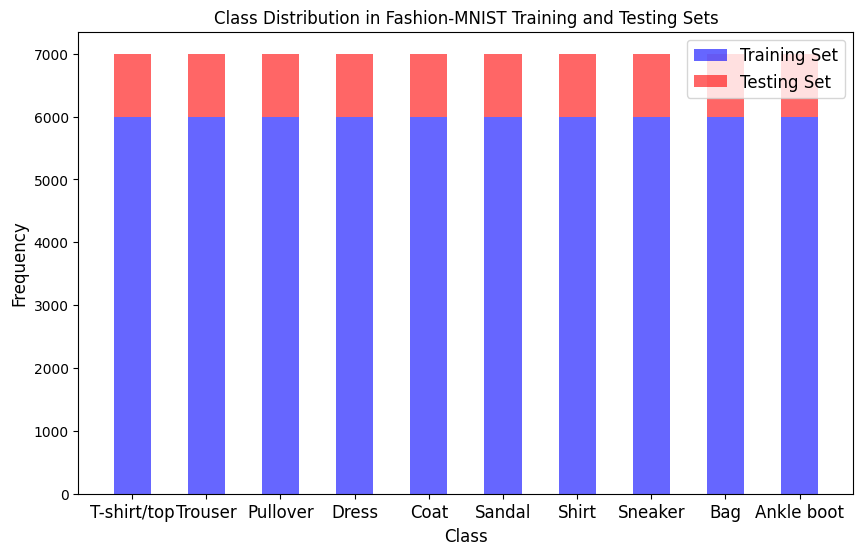

In [ ]:
# Count the number of instances in each class for training set
unique_train, counts_train = np.unique(Y_train, return_counts=True)

# Count the number of instances in each class for testing set
unique_test, counts_test = np.unique(Y_test, return_counts=True)

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot histograms
plt.bar(unique_train, counts_train, width=0.5, label='Training Set', color='blue', alpha=0.6)
plt.bar(unique_test, counts_test, width=0.5, bottom=counts_train, label='Testing Set', color='red', alpha=0.6)

# Adding title and labels
plt.title('Class Distribution in Fashion-MNIST Training and Testing Sets', fontsize= 12)
plt.xlabel('Class', fontsize= 12)
plt.ylabel('Frequency', fontsize= 12)
plt.xticks(range(len(class_labels)), class_labels, fontsize= 12)

# Adding legend
plt.legend(fontsize= 12)

# Show the plot
plt.show()

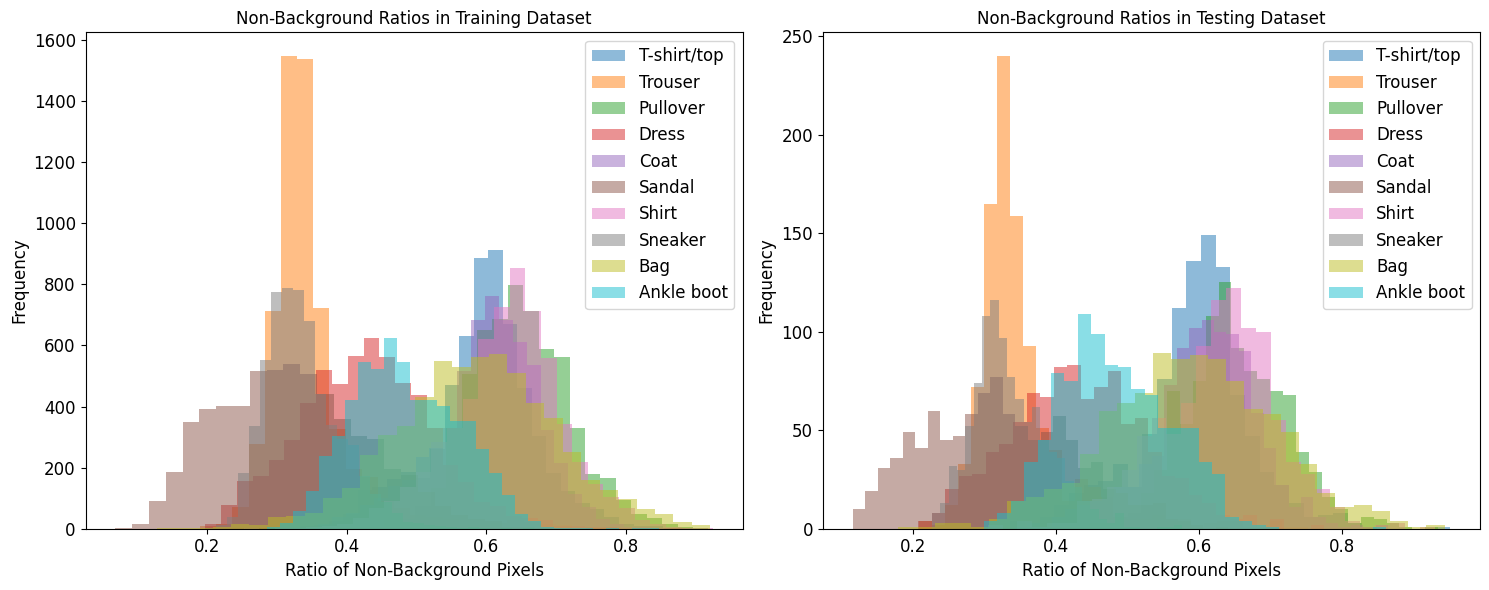

In [ ]:
# Descriptive analysis based on instance pixel ratio

def calculate_non_background_ratio(images):
  total_pixels = 28*28
  ratios = [np.count_nonzero(image) / total_pixels for image in images]
  return ratios

# Figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for training set
ratios_train = calculate_non_background_ratio(X_train)
class_ratios_train = {i: [] for i in range(10)}
for ratio, label in zip(ratios_train, Y_train):
    class_ratios_train[label].append(ratio)

for index, ratio_list in class_ratios_train.items():
    axs[0].hist(ratio_list, bins=30, alpha=0.5, label=class_labels[index])

axs[0].set_title("Non-Background Ratios in Training Dataset", fontsize= 12)
axs[0].set_xlabel("Ratio of Non-Background Pixels", fontsize= 12)
axs[0].set_ylabel("Frequency", fontsize= 12)
axs[0].legend(fontsize= 12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Plot for testing set
ratios_test = calculate_non_background_ratio(X_test)
class_ratios_test = {i: [] for i in range(10)}
for ratio, label in zip(ratios_test, Y_test):
    class_ratios_test[label].append(ratio)

for index, ratio_list in class_ratios_test.items():
    axs[1].hist(ratio_list, bins=30, alpha=0.5, label=class_labels[index])

axs[1].set_title("Non-Background Ratios in Testing Dataset", fontsize= 12)
axs[1].set_xlabel("Ratio of Non-Background Pixels", fontsize= 12)
axs[1].set_ylabel("Frequency", fontsize= 12)
axs[1].legend(fontsize= 12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Adjust layout and show the plot
plt.tight_layout()

plt.show()

In [ ]:
# Descriptive analysis based on instance pixel ratio

def create_statistics_table(class_ratios):
    stats = {
        'Q1': [],
        'Q2': [],
        'Q3': [],
        'Q4': [],
        'Mean': [],
        'Variance': []
    }

    for class_id in sorted(class_ratios.keys()):
        ratios = class_ratios[class_id]
        stats['Q1'].append(np.percentile(ratios, 25))
        stats['Q2'].append(np.median(ratios))
        stats['Q3'].append(np.percentile(ratios, 75))
        stats['Q4'].append(max(ratios))
        stats['Mean'].append(np.mean(ratios))
        stats['Variance'].append(np.var(ratios))

    return pd.DataFrame(stats, index=class_labels)

# Create tables for training and testing sets
table_train = create_statistics_table(class_ratios_train)
table_test = create_statistics_table(class_ratios_test)

# Display the tables
print("Training Set Statistics:")
print(table_train)
print("\nTesting Set Statistics:")
print(table_test)

Training Set Statistics:
                   Q1        Q2        Q3        Q4      Mean  Variance
T-shirt/top  0.557398  0.599490  0.637755  0.894133  0.594124  0.005746
Trouser      0.312500  0.332908  0.360969  0.885204  0.348677  0.004796
Pullover     0.600765  0.646046  0.695153  0.918367  0.648719  0.004985
Dress        0.364796  0.427296  0.488520  0.877551  0.427908  0.008697
Coat         0.561224  0.607143  0.651786  0.896684  0.601731  0.005624
Sandal       0.241071  0.315051  0.390306  0.790816  0.321141  0.010906
Shirt        0.584184  0.635204  0.677296  0.924745  0.629123  0.006231
Sneaker      0.299745  0.329082  0.367347  0.668367  0.337928  0.002921
Bag          0.512755  0.586735  0.660714  0.920918  0.585615  0.012982
Ankle boot   0.428571  0.477041  0.540816  0.846939  0.484520  0.005695

Testing Set Statistics:
                   Q1        Q2        Q3        Q4      Mean  Variance
T-shirt/top  0.558673  0.599490  0.638074  0.951531  0.594986  0.005972
Trouser      0

Defining our simple CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),

    layers.Flatten(),
    layers.Dense(len(classes), activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                125450    
                                                                 
Total params: 130394 (509.35 KB)
Trainable params: 130394 (509.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now let's compile and train the model

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])
model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 3s 9ms/step - loss: 0.5482 - accuracy: 0.8114 - val_loss: 0.4043 - val_accuracy: 0.8579
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 0.3498 - accuracy: 0.8765 - val_loss: 0.3620 - val_accuracy: 0.8740
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.3065 - accuracy: 0.8917 - val_loss: 0.3230 - val_accuracy: 0.8858
Epoch 4/10
235/235 [==============================] - 2s 8ms/step - loss: 0.2793 - accuracy: 0.9013 - val_loss: 0.3123 - val_accuracy: 0.8922
Epoch 5/10
235/235 [==============================] - 2s 8ms/step - loss: 0.2597 - accuracy: 0.9074 - val_loss: 0.3052 - val_accuracy: 0.8885
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: 0.2430 - accuracy: 0.9125 - val_loss: 0.2899 - val_accuracy: 0.8969
Epoch 7/10
235/235 [==============================] - 3s 12ms/step - loss: 0.2292 - accuracy: 0.9181 - val_loss: 0.2934 - val_accuracy: 0.8954
Epoc

Evaluating the model's performance

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_test_preds = model.predict(X_test)
Y_test_preds = np.argmax(Y_test_preds, axis=1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_test, Y_test_preds))
print("\nClassification Report :")
print(classification_report(Y_test, Y_test_preds, target_names=class_labels))

313/313 [==============================] - 1s 3ms/step
Test Accuracy : 0.9093

Confusion Matrix : 
[[906   0  17  24   2   2  43   0   6   0]
 [  1 983   0  10   2   0   2   0   2   0]
 [ 20   1 863  11  59   1  43   0   2   0]
 [ 15   6  11 946  11   0  11   0   0   0]
 [  2   1  47  46 869   0  34   0   1   0]
 [  0   0   0   1   0 976   0  12   1  10]
 [159   2  75  41  64   0 653   0   6   0]
 [  0   0   0   0   0  12   0 958   0  30]
 [  4   3   3   4   3   2   3   3 975   0]
 [  0   0   0   0   0   8   2  26   0 964]]

Classification Report :
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.91      0.86      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.86      0.86      1000
       Dress       0.87      0.95      0.91      1000
        Coat       0.86      0.87      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.83      0.65      0.73      1000
     Sneaker

## EXPLANATION PART

In [ ]:
#initializing shap
shap.initjs()

In [ ]:
#creating an instance of PARTITION EXPLAINER
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

explainer

#masker is used to mask the parts of an image using blurring or inpainting.

In [ ]:
#visualizing SHAP values for Correct Predictions

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 5)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
1/1 [==============================] - 0s 113ms/step
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99248135 0.9989568  0.9999993  0.99999976]


Image Plot


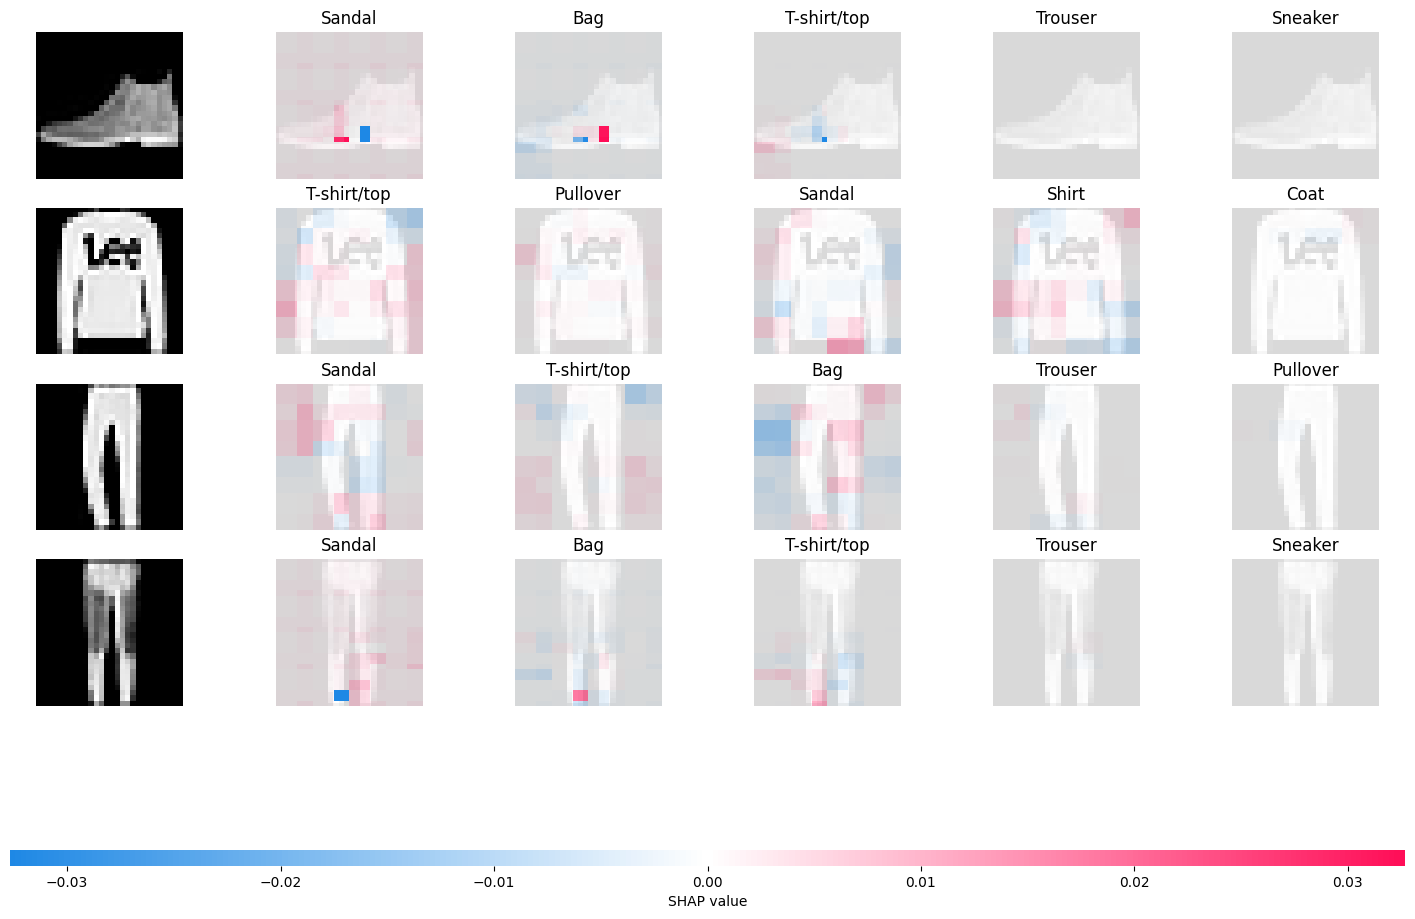

In [ ]:
shap.image_plot(shap_values)

Depicts the first 6 categories that the model thinks the image belongs to

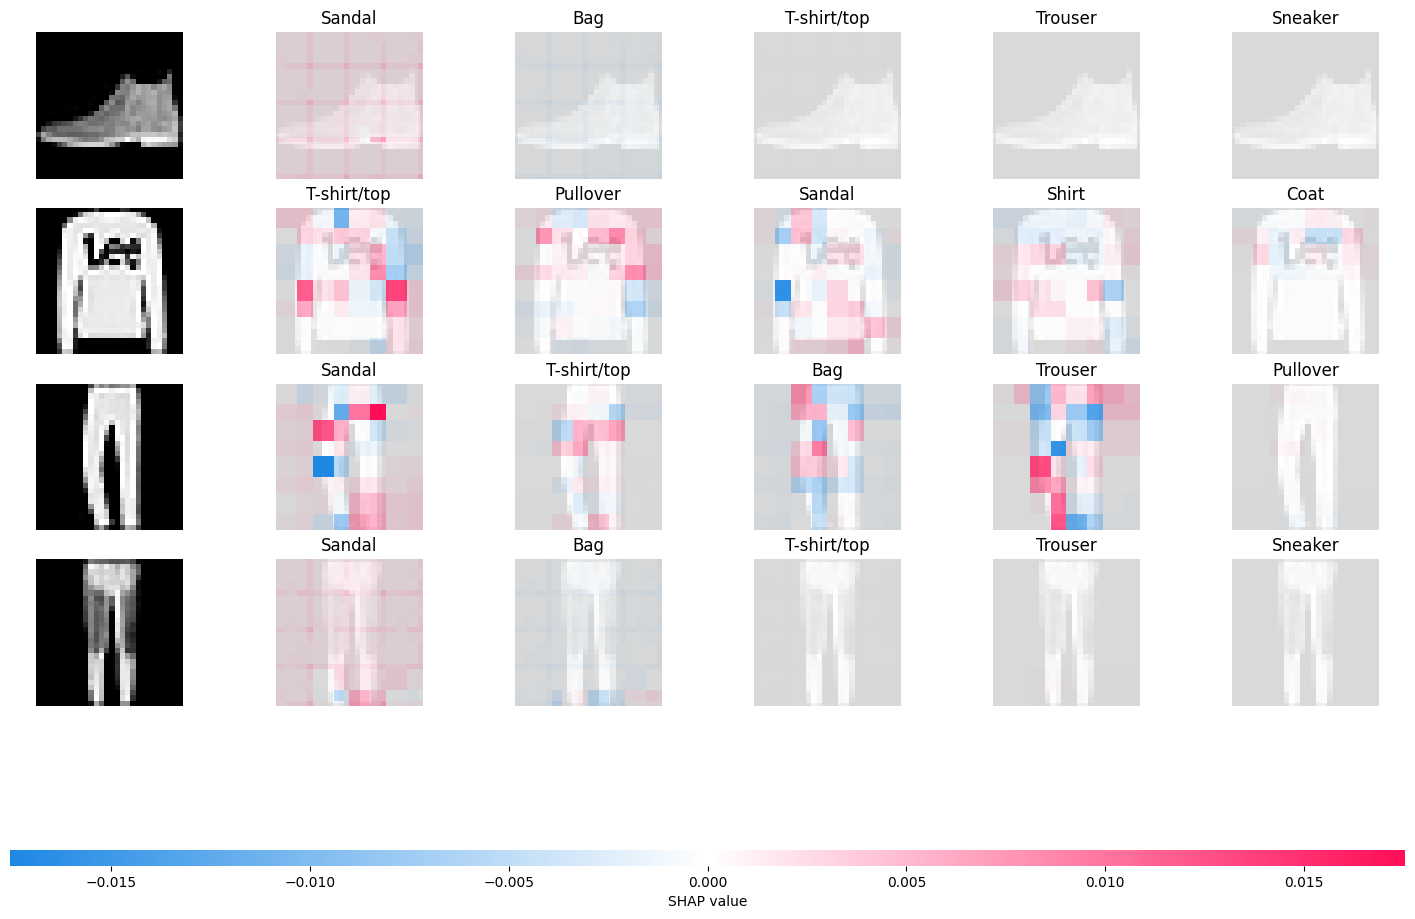

In [ ]:
# another image plot using different masker called inpaint_ns

masker = shap.maskers.Image("inpaint_ns", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

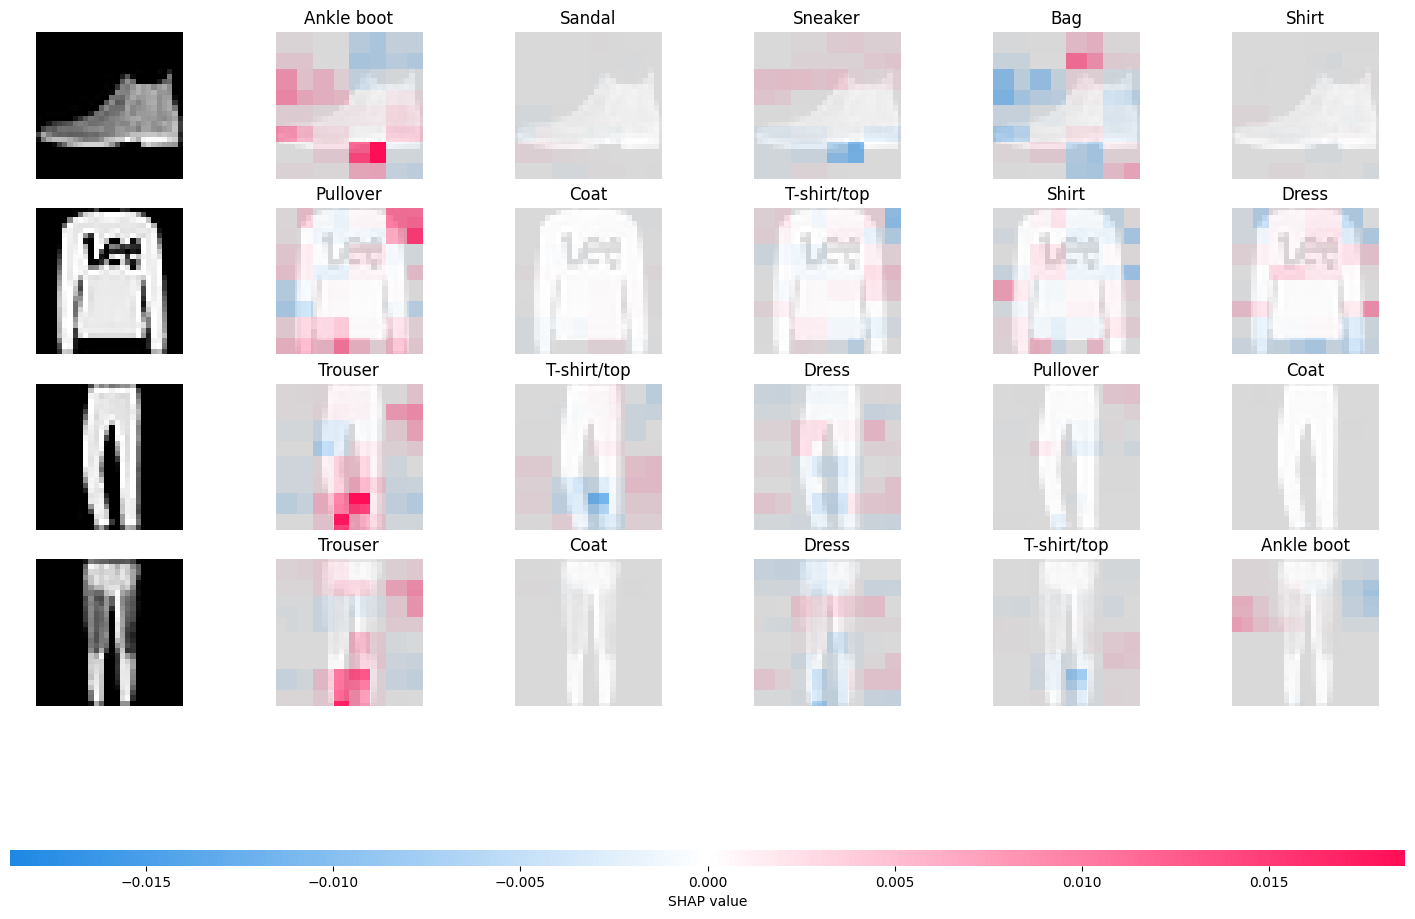

In [ ]:
# another image plot using blurring-based masker

masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

Now let's visualize SHAP for incorrect predictions

In [ ]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)

X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]

print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
1/1 [==============================] - 0s 17ms/step
Predicted Labels : ['Sandal', 'Sandal', 'Pullover', 'Trouser']
Probabilities : [0.74319595 0.9997607  0.47391585 0.51794785]


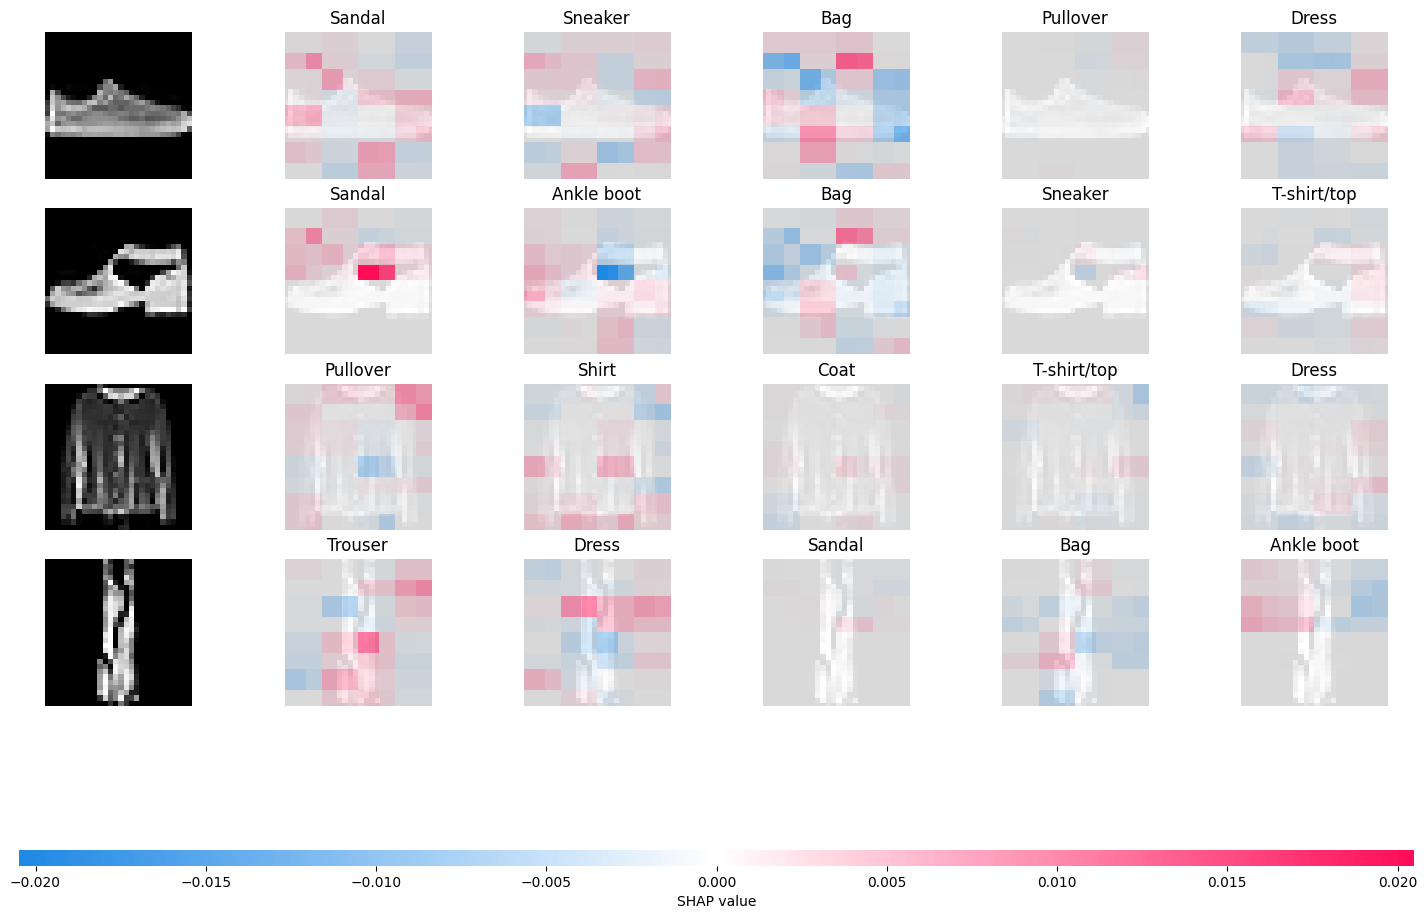

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_batch, outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

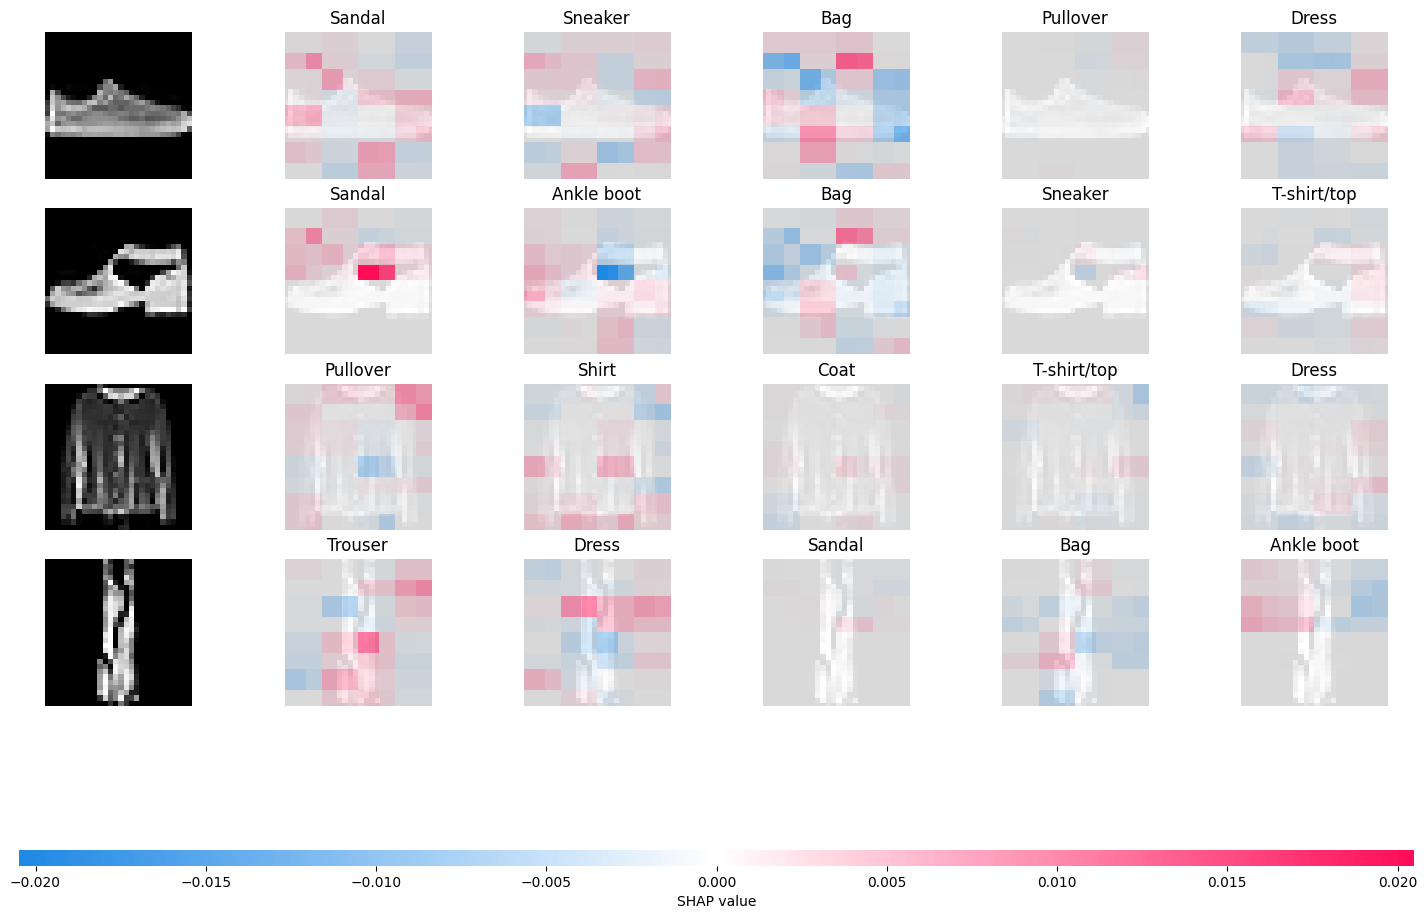

In [ ]:
shap.plots.image(shap_values)

SHAP Permutation Explainer



1.   For correct predictions



In [ ]:
# tries different combinations of features to generate shap values

masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)

explainer

<shap.explainers._permutation.PermutationExplainer.__init__.<locals>.PermutationExplainer at 0x7f5199772560>

In [ ]:
shap_values = explainer(X_test[:4], max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 10)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
1/1 [==============================] - 0s 29ms/step
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99248135 0.9989568  0.9999993  0.99999976]


In [ ]:
Y_preds = model.predict(X_test[:4])

Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)

Y_labels

1/1 [==============================] - 0s 37ms/step


array([['Ankle boot', 'Sandal', 'Sneaker', 'Bag', 'Shirt', 'Pullover',
        'T-shirt/top', 'Coat', 'Dress', 'Trouser'],
       ['Pullover', 'Coat', 'T-shirt/top', 'Shirt', 'Dress', 'Bag',
        'Trouser', 'Ankle boot', 'Sandal', 'Sneaker'],
       ['Trouser', 'T-shirt/top', 'Dress', 'Pullover', 'Coat', 'Sandal',
        'Bag', 'Shirt', 'Ankle boot', 'Sneaker'],
       ['Trouser', 'Coat', 'Dress', 'T-shirt/top', 'Ankle boot', 'Shirt',
        'Pullover', 'Bag', 'Sandal', 'Sneaker']], dtype='<U11')

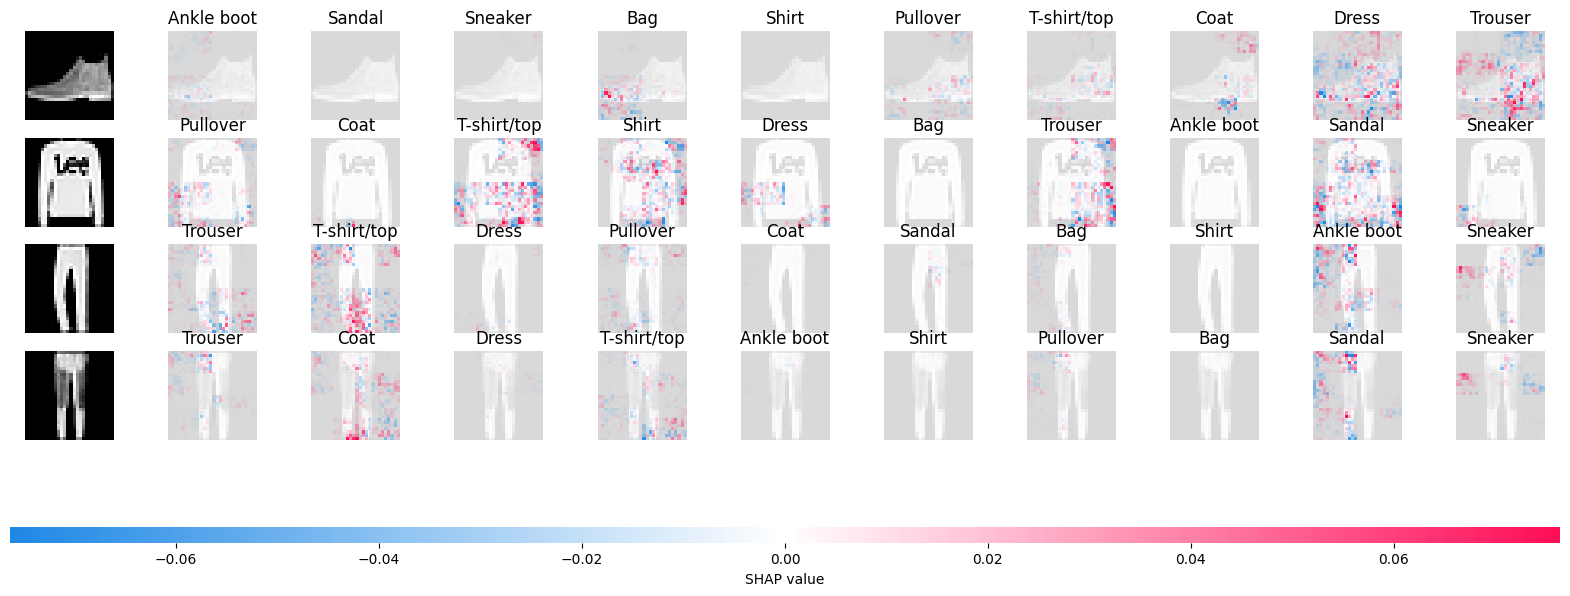

In [ ]:
# this shows the image plot showing shap values that contributed to predictions

shap.image_plot(shap_values, labels=Y_labels)

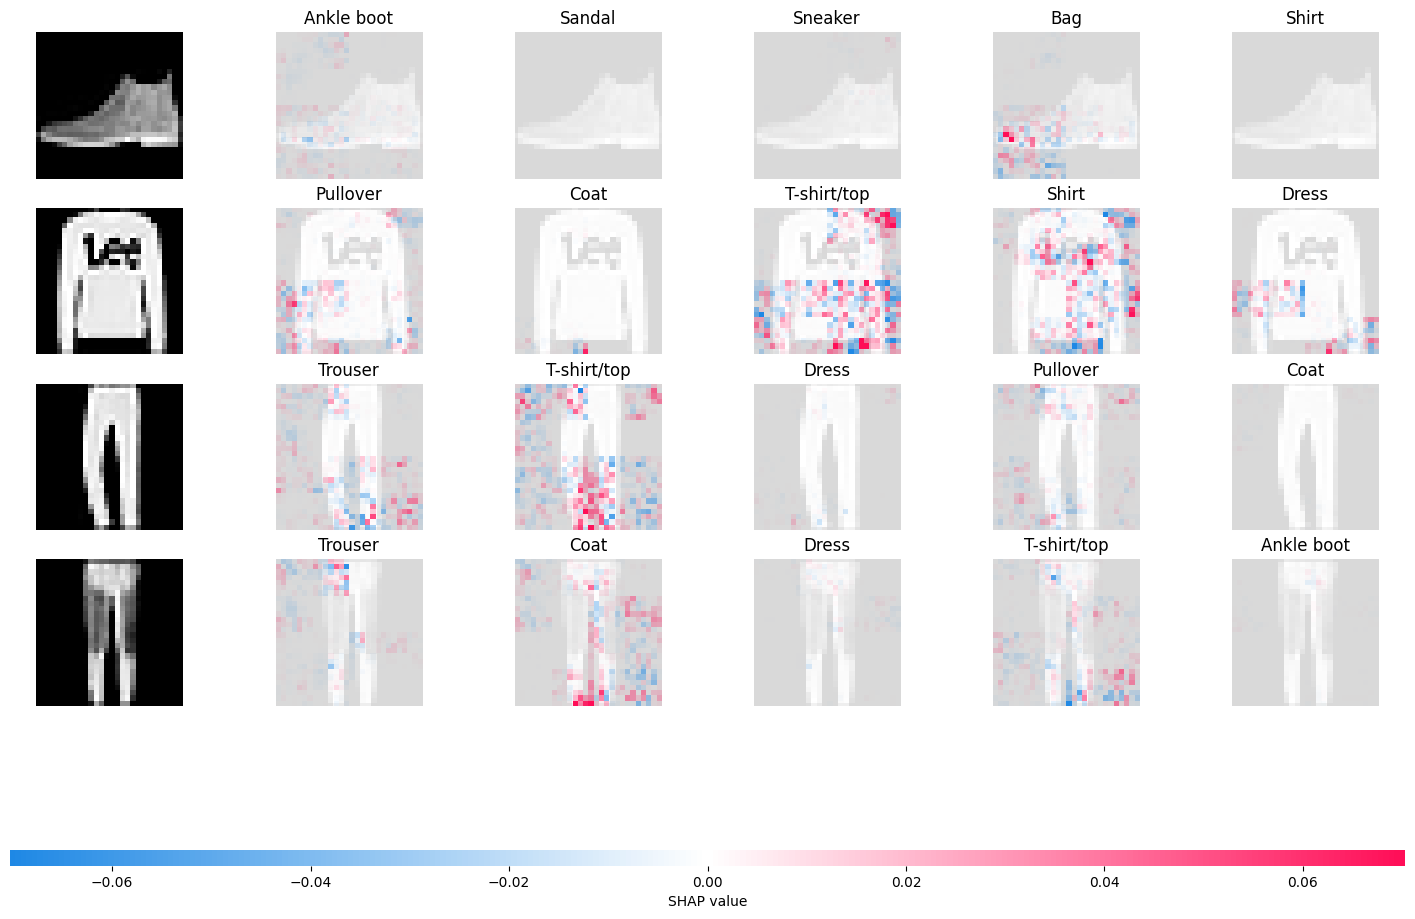

In [ ]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])

2.   For incorrect predictions

In [ ]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)

X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]

print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
1/1 [==============================] - 0s 17ms/step
Predicted Labels : ['Sandal', 'Sandal', 'Pullover', 'Trouser']
Probabilities : [0.74319595 0.9997607  0.47391585 0.51794785]


In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)

shap_values = explainer(X_batch, max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 10)

In [ ]:
Y_preds = model.predict(X_batch)

Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)

Y_labels

1/1 [==============================] - 0s 17ms/step


array([['Sandal', 'Sneaker', 'Bag', 'Pullover', 'Dress', 'Shirt',
        'Ankle boot', 'T-shirt/top', 'Trouser', 'Coat'],
       ['Sandal', 'Ankle boot', 'Bag', 'Sneaker', 'T-shirt/top', 'Shirt',
        'Pullover', 'Dress', 'Coat', 'Trouser'],
       ['Pullover', 'Shirt', 'Coat', 'T-shirt/top', 'Dress', 'Trouser',
        'Bag', 'Ankle boot', 'Sandal', 'Sneaker'],
       ['Trouser', 'Dress', 'Sandal', 'Bag', 'Ankle boot', 'Shirt',
        'Sneaker', 'T-shirt/top', 'Pullover', 'Coat']], dtype='<U11')

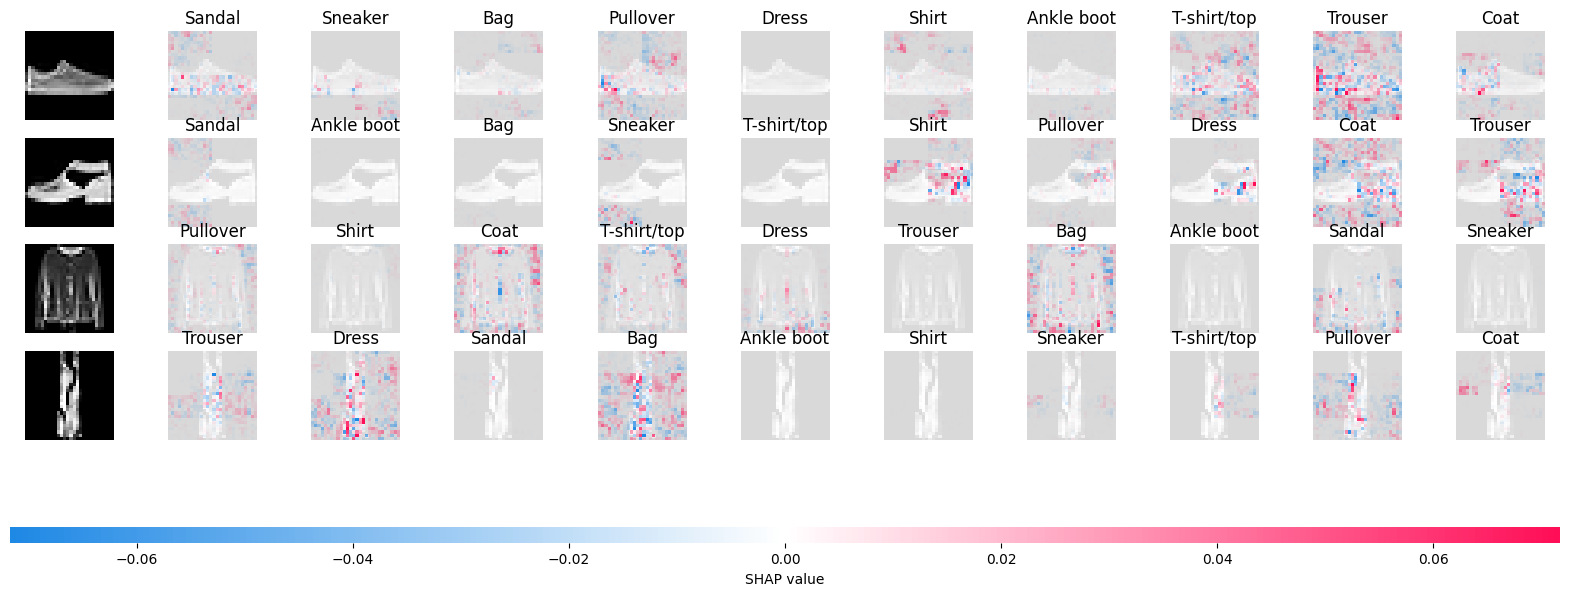

In [ ]:
shap.image_plot(shap_values, labels=Y_labels)

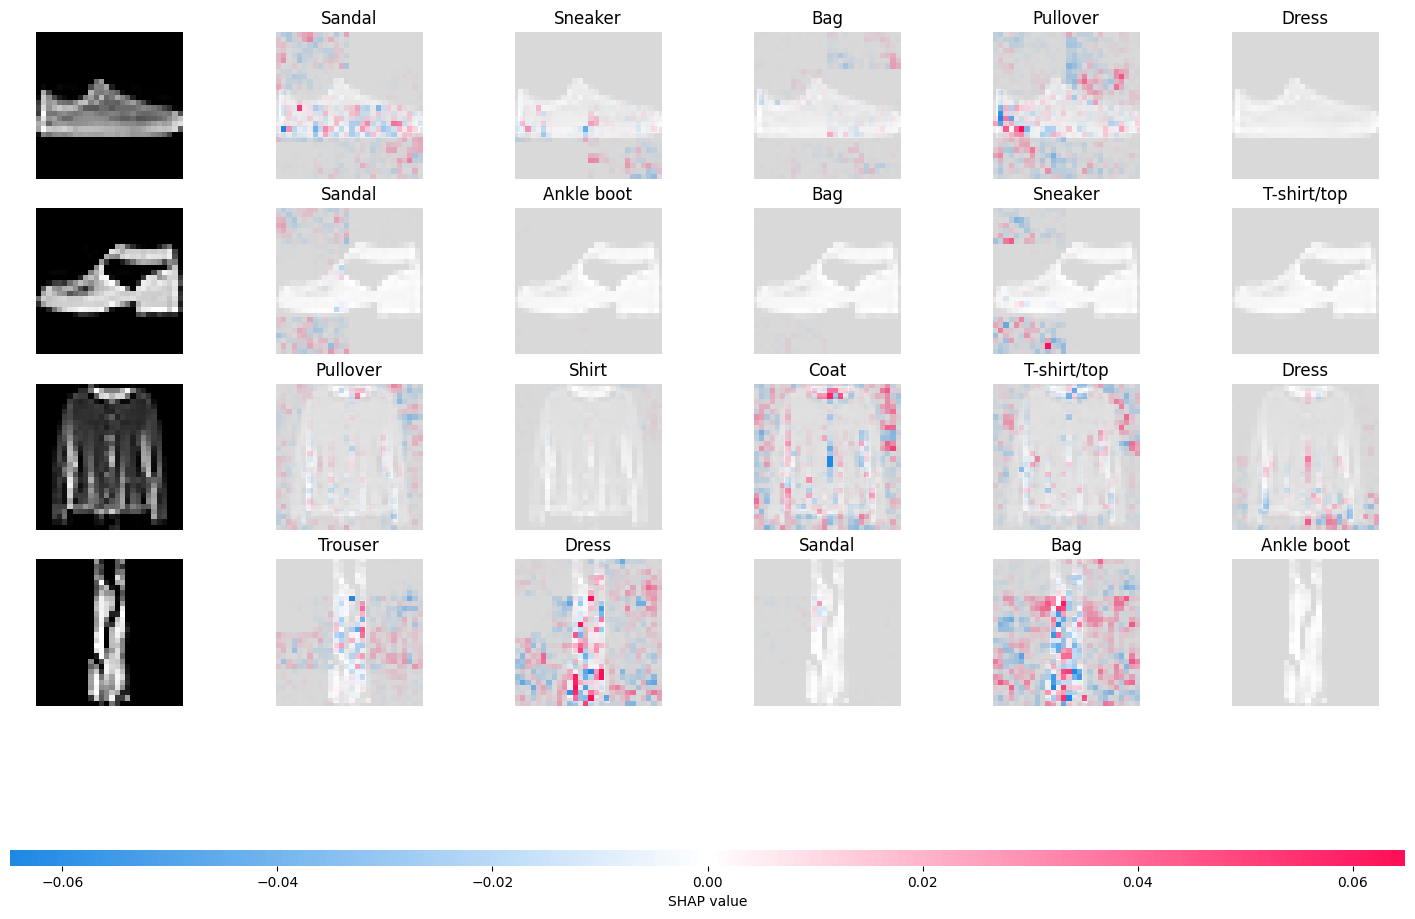

In [ ]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])

## GradCAM


In [ ]:
# GradCAM
def generate_gradcam(img, model, class_idx, last_conv_layer_name):
    img_reshaped = np.reshape(img, (1, 28, 28, 1))

    # Get the output of the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_output = last_conv_layer.output

    # Model that maps from model inputs to the last conv layer output
    grad_model = tf.keras.Model([model.inputs], [last_conv_layer.output, model.output])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_reshaped)
        loss = predictions[:, class_idx]

    # Gradients with respect to the last conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Mean intensity of the gradient over the feature map axis
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Reshape for correct broadcasting
    pooled_grads = tf.reshape(pooled_grads, [1, 1, len(pooled_grads)])

    # Weigh the output feature map with these gradients
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Process the class activation map for visualization
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / tf.reduce_max(cam)  # Normalize
    cam = cv2.resize(cam.numpy(), (28, 28))

    return cam

NameError: name 'x_test' is not defined

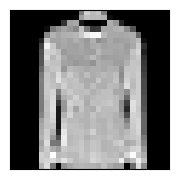

In [ ]:
# random sampling for test results visualization
figure = plt.figure(figsize=(25, 12))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=50, replace=False)):
    ax = figure.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]), cmap='gray')

    # GradCAM for the current image
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    preds = model.predict(np.reshape(x_test[index], (1, 28, 28, 1)))
    class_idx = np.argmax(preds[0])
    gradcam = generate_gradcam(x_test[index], model, class_idx, last_conv_layer_name)

    ax.imshow(gradcam, cmap='magma', alpha=0.5)

    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                 color=("green" if predict_index == true_index else "red"))


plt.show()